# Imports

In [1]:
import sys
import torch
import pickle
import numpy as np
import pandas as pd
import seaborn as sbrn
from pandas import DataFrame
from numpy.linalg import norm
import matplotlib.pyplot as plt
from matplotlib import rcParams

from sklearn import metrics
from sklearn.linear_model import LogisticRegression

%matplotlib inline

sbrn.set(font='Helvetica')
plt.style.use('default')
rcParams['font.family'] = 'Helvetica'
rcParams['font.size'] = 20
rcParams['pdf.fonttype'] = 42
plt.rcParams.update({"text.color": 'k'})
rcParams["axes.unicode_minus"] = True




# SVD

In [2]:


def l1_scaling(X):
    """l1 normalize along the last index.
    
    Fix all but the last index and scale the resulting
    vector to unit l1 norm. Can be used to scale sequencing
    data to the same read depth.
    """
    Xn = torch.norm(X, p=1, dim=-1, keepdim=True)
    return X.div(Xn)

def col_norm(X):
    """l1 normalize along the first index.
    
    Fix all but the last index and scale the resulting
    vector to unit l1 norm. Can be used to scale sequencing
    data to the same read depth.
    """
    Xn = torch.norm(X, p=1, dim=0, keepdim=True)
    return X.div(Xn)


sys.path.append('./')


binsize = 1000
input_dir = './Pickle/DeCET_HEK6/' 
file_prefix = 'DeCET_HEK6_'+str(binsize) 
hosvd_file = file_prefix+'_HOSVD'
output_dir = './binsiz'+str(binsize)+'/' 

fp = open(input_dir + hosvd_file + '_projections.txt', 'r')

index = []
projections = []
for line in fp:
    l = line.strip().split(':')
    index.append([int(l[0].split(',')[0])])
    projections.append(l[1].strip().split(','))

n_pt = 6
fp.close()

# rows correspond to the jth singular vector, columns refer to the ith sample
sample_proj = np.zeros((n_pt, len(projections[0])))

for k in range(0,len(projections)):
    sample_proj[index[k]]= projections[k]
    
n_as = 1
U_l = (torch.load(input_dir + hosvd_file + '_factor_matrix_1.pt', map_location='cpu')).numpy()
n_lc = 3
L_genome = U_l.shape[0]

tv = np.zeros((3,n_lc))
cv = np.zeros((3,n_lc))
indices = [0,1]
for i in indices:
    for j in range(np.shape(tv)[1]):
        tv[i,j] = sample_proj[i,j]
        cv[i,j] = sample_proj[i+3,j]

averages = np.zeros(n_lc)
for i in range(np.shape(tv)[1]):
    averages[i] = np.mean(tv[:,i])-np.mean(cv[:,i])

coef = averages/(norm(averages))

tensor = l1_scaling(torch.load(input_dir + file_prefix + '.pt', map_location='cpu')).numpy()
lc = np.zeros(len(U_l))
for i in range(len(coef)):
    lc += coef[i]*U_l[:,i]
lc_proj = np.transpose(np.array([[np.dot(tensor[i,:],lc) for i in range(len(tensor))]]))
sample_proj_lc = np.hstack((sample_proj, lc_proj))

/var/folders/nl/trpkw4cx7ml_mqyy6073zj9r0000gp/T/ipykernel_65817/1738525471.py:12: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  ax['A'].plot(sample_proj[k],'.', markersize=6, color = C[k], marker = M[k], label = L[k], alpha = 0.5)
/var/folders/nl/trpkw4cx7ml_mqyy6073zj9r0000gp/T/ipykernel_65817/1738525471.py:12: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  ax['A'].plot(sample_proj[k],'.', markersize=6, color = C[k], marker = M[k], label = L[k], alpha = 0.5)
/var/folders/nl/trpkw4cx7ml_mqyy6073zj9r0000gp/T/ipykernel_65817/1738525471.py:12: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  ax['A'].plot(sample_proj[k],'.', markersize=6, color = C[k], m

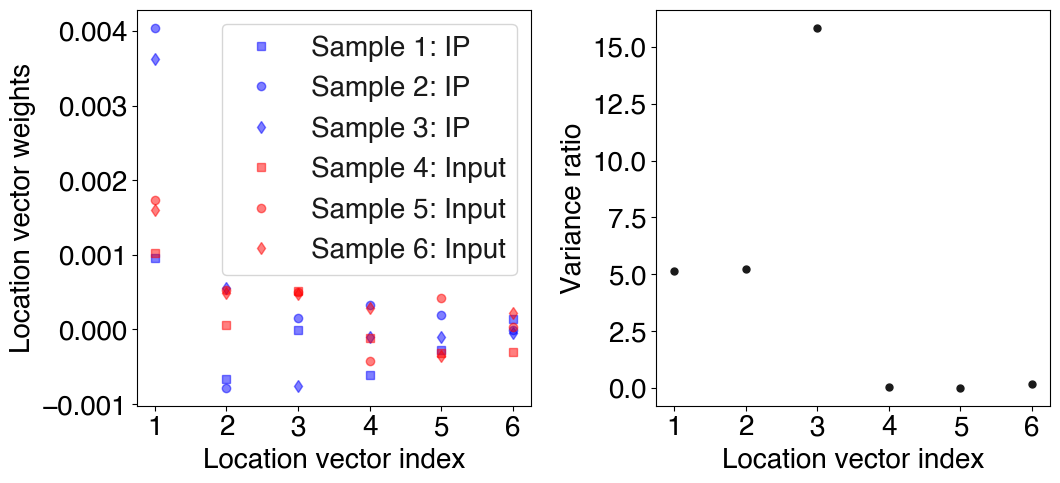

In [3]:
fig, ax = plt.subplot_mosaic("AB",figsize=(11,5.23))

n_proj = 6 

L = ['Sample 1: IP', 'Sample 2: IP',  'Sample 3: IP', 'Sample 4: Input','Sample 5: Input', 'Sample 6: Input']


C = ['blue']*3+['red']*3
M = ['s', 'o', 'd']*2

for k in range(0,np.shape(sample_proj)[0]):
    ax['A'].plot(sample_proj[k],'.', markersize=6, color = C[k], marker = M[k], label = L[k], alpha = 0.5)
ax['A'].legend()  

ax['A'].set_xlabel('Location vector index')
ax['A'].set_ylabel('Location vector weights')
ax['A'].set_xticklabels([1,2,3,4,5,6])
ax['A'].set_xticks([0,1,2,3,4,5])


n_loc = len(U_l[0,:])
n_as = 1
full_var_ratio = np.zeros(n_loc)
wGroupVar = np.zeros((n_as, n_loc))
bGroupVar = np.zeros((n_as, n_loc))

n_ip = 3
n_in = 3 
n_gr = 2

for l in range(n_loc):
    for k in range(n_as):
        bGroupVar[k,l] = n_ip*(np.mean(sample_proj_lc[0:n_ip, l]) - np.mean((sample_proj_lc[:,l])))**2 +\
                         n_in*(np.mean(sample_proj_lc[n_ip:n_ip+n_in, l]) - np.mean((sample_proj_lc[:,l])))**2
        
        wGroupVar[k,l] = sum( np.power(sample_proj_lc[0:n_ip,l] - np.mean(sample_proj_lc[0:n_ip,l]),2) ) +\
                         sum( np.power(sample_proj_lc[n_ip:n_ip+n_in, l] - np.mean(sample_proj_lc[n_ip:n_ip+n_in,l]),2) )
    full_var_ratio[l] = (sum(bGroupVar[:,l])/(n_as*(n_gr-1)))/(sum(wGroupVar[:,l])/(n_as*(n_gr*n_pt - n_gr)))

ax['B'].plot(range(1,n_loc+1)[:30],(full_var_ratio)[-30:],'.k', markersize=10)
ax['B'].set_xticklabels([1,2,3,4,5,6])
ax['B'].set_xticks([1,2,3,4,5,6])
ax['B'].set_xlabel('Location vector index')
ax['B'].set_ylabel('Variance ratio')
plt.tight_layout()




In [4]:
folder = './Pickle/DeCET_HEK6/'

prefix = 'DeCET_HEK6_'+str(binsize)

cutoff = [80, 95]
for term in cutoff:
    cut = np.percentile(np.absolute(lc), term, interpolation='nearest')
    lincomb_pos = []
    lincomb_neg = []
    for i in range(L_genome):
        if(lc[i] > cut):
            lincomb_pos.append(i)
        elif(lc[i] < -cut):
            lincomb_neg.append(i)

    genomic = pickle.load(open(folder+prefix+'_index_to_genomic.pkl', 'rb'))
    for i in range(len(genomic)):
        for j in range(3):
            genomic[i][j] = str(genomic[i][j])
    lincomb_pos_bed = []
    for item in lincomb_pos: 
        lincomb_pos_bed.append(genomic[item])
    lincomb_neg_bed = []
    for item in lincomb_neg: 
        lincomb_neg_bed.append(genomic[item])


/var/folders/nl/trpkw4cx7ml_mqyy6073zj9r0000gp/T/ipykernel_65817/739876243.py:7: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they. (Deprecated NumPy 1.22)
  cut = np.percentile(np.absolute(lc), term, interpolation='nearest')


# Logistic Regression

In [5]:
def logistic_cutoff(array, cutoff):
    zero = np.zeros(len(array))
    for i in range(len(zero)):
        if array[i] > cutoff:
            zero[i] = 1
    return(zero)
        
def cm(log_dist, indedt, thresh, norm = False):
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    for i in range(len(log_dist)):
        if log_dist[i] < thresh and indedt[i] == 0:
            tn += 1
        elif log_dist[i] > thresh and indedt[i] == 1:
            tp += 1
        elif log_dist[i] > thresh and indedt[i] == 0:
            fp += 1
        elif log_dist[i] < thresh and indedt[i] == 1:
            fn += 1
    if norm == False:
        CM = np.array([[tp, fn], [fp, tn]])
        return(CM)
    elif norm == True:
        CM = np.array([[tp/(tp+fn), fn/(tp+fn)], [fp/(fp+tn), tn/(fp+tn)]])
        return(np.round(CM, decimals=2))

def confuse(DF, lable, norm = False):
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    for i in range(len(DF)):
        if DF[i] == 0 and lable[i] == 0:
            tn += 1
        elif DF[i] == 1 and lable[i] == 1:
            tp += 1
        elif DF[i] == 1 and lable[i] == 0:
            fp += 1
        elif DF[i] == 0 and lable[i] == 1:
            fn += 1
    if norm == False:
        CM = np.array([[tp, fn], [fp, tn]])
        return(CM)
    elif norm == True:
        CM = np.array([[tp/(tp+fn), fn/(tp+fn)], [fp/(fp+tn), tn/(fp+tn)]])
        return(np.round(CM, decimals=2))




In [6]:
edit_threshold = 1.0
header = 'Lincomb3_pos_binsize1000_base80_seed95'


LogR = LogisticRegression()
endo = pd.read_csv('Kim_endogenous.csv')
endo_dist = np.log10(endo[[header]].values)
endo_edt = endo['BR12 Average Editing Percentage'].values

endo_indedt = logistic_cutoff(endo_edt, edit_threshold)
LogR.fit((endo_dist), endo_indedt)
logr_predict = LogR.predict((endo_dist))

logr_decfunct = LogR.predict_proba((endo_dist))[:,1]
fpr, tpr, threshold = metrics.roc_curve(endo_indedt, logr_decfunct)
roc_auc = metrics.auc(fpr, tpr)

opt = np.round(threshold[np.argmax(tpr - fpr)], decimals = 4)

plr=[]
for x in range(len(tpr)):
    if fpr[x] == 0:
        plr.append(0)
    else:
        plr.append(np.round(tpr[x]/fpr[x],decimals = 3))
indices = []
for x in range(len(plr)):
    if plr[x] == max(plr):
        indices.append(x)

X_test = np.arange(-2, 8.5, 0.0001)
logistic = expit(X_test * LogR.coef_ + LogR.intercept_).ravel()
for i in range(len(logistic)):
    if np.round(logistic, 4)[i] == opt:
        break


confusion = cm(endo_dist.ravel(), endo_indedt, X_test[i], norm = True)


inhouse = pd.read_csv('Liu_Perez.csv')
inhouse_dist = np.log10(inhouse[[header]].values)
inhouse_edt = inhouse['Edit Rate Averaged'].values*100
inhouse_indedt = logistic_cutoff(inhouse_edt, edit_threshold)
logr_predict = LogR.predict((inhouse_dist))

logr_decfunct = LogR.predict_proba((inhouse_dist))[:,1]
fpr, tpr, threshold = metrics.roc_curve(inhouse_indedt, logr_decfunct)
roc_auc = metrics.auc(fpr, tpr)
fig, ax = plt.subplot_mosaic("AA;BC",figsize=(10,13.5*(2/3)),gridspec_kw={'width_ratios': [0.9,1]})
ax['B'].plot(1-tpr, 1-fpr, 'b', label = 'AUC = %0.2f' % roc_auc)
ax['B'].legend(loc = 'lower right',fontsize=18)
ax['B'].plot([0, 1], [0, 1],'r--')
ax['B'].set_xlim([0-0.02, 1+0.02])
ax['B'].set_ylim([0-0.02, 1+0.02])
ax['B'].set_ylabel('True positive rate')
ax['B'].set_xlabel('False positive rate')

confusion = cm(inhouse_dist.ravel(), inhouse_indedt, X_test[i], norm = True)

sbrn.heatmap(confusion, annot = True, cmap = 'Blues', ax=ax['C'])
ax['C'].set_xticks(np.arange(2)+0.5)
ax['C'].set_xticklabels(['Strongly\neditable\n(1)','Weakly\neditable\n(0)'])
ax['C'].set_yticks(np.arange(2)+0.5)
ax['C'].set_yticklabels(['Strongly\neditable\n(1)    ','Weakly\neditable\n(0)    '])
ax['C'].set_xlabel('Predicted')
ax['C'].set_ylabel('Observed')

ax['A'].scatter((inhouse_dist[0:25]), inhouse_indedt[0:25], s=100,color=(1,95/255,5/255), marker = 'x')
ax['A'].scatter((inhouse_dist[25:33]), inhouse_indedt[25:33], s=20,color='navy', marker = 's')
X_test = np.arange(-2, 8.5, 0.0001)
logistic = expit(X_test * LogR.coef_ + LogR.intercept_).ravel()
ax['A'].plot(X_test, logistic, color='black', linewidth=2)
for i in range(len(logistic)):
    if np.round(logistic, 4)[i] == opt:
        break
d_thresh = X_test[i]
ax['A'].axvline(X_test[i], color = 'grey', linestyle='--')
ax['A'].legend(['In-house experimental data','Anzalone $\it{et}$ $\it{al}$. data', 'Logistic curve trained\non Kim $\it{et}$ $\it{al}$. data', 'Distance threshold'],loc='upper left',fontsize=17)
ax['A'].set_xlabel('Log$_{1}$$_{0}$ distance to H3K9me3 peak')
ax['A'].set_ylabel('Probability')
plt.tight_layout()



NameError: name 'expit' is not defined